# Cross-Device Graph calculation

This notebook can be used for calculating a Cross-Device Graph.

## Dependencies

The notebook requires 
1. Python, Jupyter, Spark and Apache Toree to be installed in order to run
1. A folder `anonymised-tracking-event-data`, containing ids to compute the graph from in the same directory as this notebook

## Installation

### 1. Install Python

This guid will cover MacOS installation, for any guidance for your OS, please check with [www.python.org](https://www.python.org/).

```
brew install python
```

### 2. Install Spark

This guid will cover MacOS installation, for any guidance for your OS, please check with [spark.apache.org](https://spark.apache.org/).

```
brew install apache-spark
```

Notice the installation path, it will be used further:
```
brew list apache-spark
```
On my machine it's (most of the output is replaced with "...")
```
/usr/local/Cellar/apache-spark/2.2.0/bin/find-spark-home
...
/usr/local/Cellar/apache-spark/2.2.0/libexec/jars/ (209 files)
...
```

### 3. Install Jupyter and Apache Toree

Use the following commands to install Jupyter and iPython kernel. iPython kernel is optional for this notebook, but a must for people who prefer Python to Scala.
```
pip install --upgrade jupyter
pip install --upgrade ipykernel
```

Use the following commands to install Apache Toree. Please make sure, that the `SPARK_HOME` path corresponds to the one reported earlier by `brew list apache-spark` or your spark installation directory if you are not running a MacOS.

```
pip install --upgrade https://dist.apache.org/repos/dist/dev/incubator/toree/0.2.0/snapshots/dev1/toree-pip/toree-0.2.0.dev1.tar.gz
```
```
SPARK_HOME=/usr/local/Cellar/apache-spark/2.2.0/libexec jupyter toree install --spark_opts='--conf "spark.jars.packages=graphframes:graphframes:0.5.0-spark2.1-s_2.11,org.knowm.xchart:xchart:3.5.0" --conf "spark.sql.parquet.binaryAsString=true" --conf "spark.executor.extraJavaOptions=-XX:+UseG1GC" --driver-memory 4g' --ToreeInstall.user=True
```

Note that the command above sets the following:
 * Toree will install GraphFrames Spark package as well as XChart charting library for you to be accessible in Toree notebooks
 * A G1 garbage collector is chosen – you can remove that setting if you don't want that
 * Spark's `--driver-memory` is set to be **4GB**

## Running

As long as everything is ready, just start the Jupyter and open this notebook. 
```
jupyter notebook
```

Go to [localhost:8888](localhost:8888) and navigate to this notebook. 

Have fun experimenting!

# Code starts below this line
---

The following section contains a bunch of useful Spark imports

In [1]:
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions._

The following code contains XChart stuff:
 * imports
 * chart colors
 * Scala-to-Java type conversions
 * a method `displayChart`, which embeds any XChart into Jupyter notebook as a Base64-encoded image

In [2]:
import org.knowm.xchart._
import org.knowm.xchart.style._
import org.knowm.xchart.style.colors._
import scala.collection.JavaConversions._
import scala.collection.mutable

def ggPlot2Colors = Array("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", 
                          "#A65628", "#F781BF", "#999999").map(hex => java.awt.Color.decode(hex))

def javaList[T](values: T*): java.util.List[T] = {
  val buffer = mutable.ListBuffer(values: _*)
  val list: java.util.List[T] = buffer
  list
}

def javaDoubleList(nums: Double*): java.util.List[java.lang.Double] = {
  val buffer = mutable.ListBuffer(nums: _*)
  val list: java.util.List[Double] = buffer
  list.map(v => new java.lang.Double(v.doubleValue))
}

def javaLongList(nums: Long*): java.util.List[java.lang.Long] = {
  val buffer = mutable.ListBuffer(nums: _*)
  val list: java.util.List[Long] = buffer
  list.map(v => new java.lang.Long(v.longValue))
}

import java.util.Base64

def displayChart(chart: internal.chartpart.Chart[_ <: style.Styler, _ <: internal.series.Series]) {
    val imageBytes = BitmapEncoder.getBitmapBytes(chart, BitmapEncoder.BitmapFormat.PNG)
    val imageBase64 = Base64.getEncoder().encodeToString(imageBytes)
    kernel.display.content("image/png", imageBase64)
}

# Reading tracking data

The following code just reads tracking data and puts it into a Spark storage (by default, it's `MEMORY_AND_DISK`).

In [40]:
val tracking = spark.read.parquet("./anonymised-tracking-event-data")
println("\nTracking data schema")
tracking.printSchema
println("\nFirst 5 rows from tracking data")
tracking.show(5, false)


Tracking data schema
root
 |-- timestamp: string (nullable = true)
 |-- cookie_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- date: integer (nullable = true)


First 5 rows from tracking data
+----------+-----------------+------------------+---------+--------+
|timestamp |cookie_id        |customer_id       |device_id|date    |
+----------+-----------------+------------------+---------+--------+
|1509793200|cookie_id_1534954|customer_id_772842|null     |20171105|
|1509793209|cookie_id_1072125|null              |null     |20171105|
|1509793212|cookie_id_2277577|customer_id_43523 |null     |20171105|
|1509793214|cookie_id_454817 |customer_id_801126|null     |20171105|
|1509793214|cookie_id_2125957|customer_id_437070|null     |20171105|
+----------+-----------------+------------------+---------+--------+
only showing top 5 rows



Let's check out the id counts

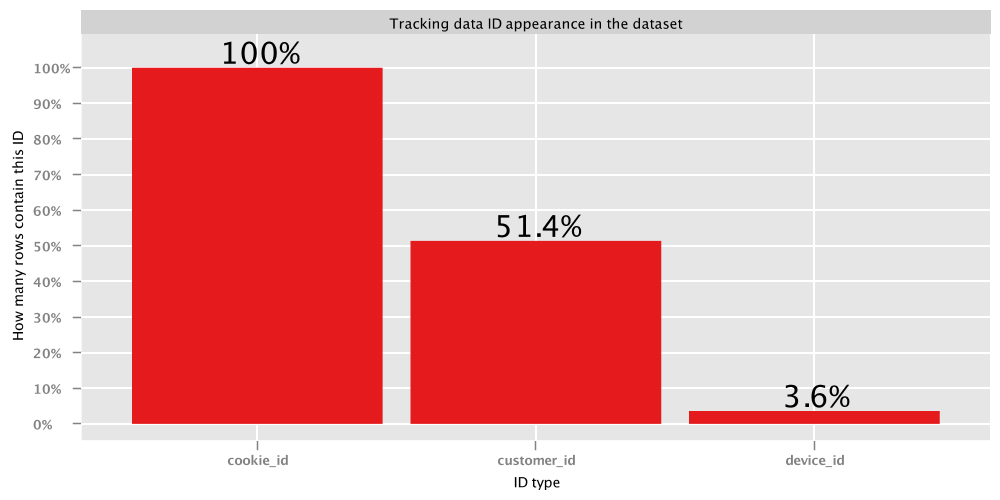

In [55]:
{
    import tracking.sqlContext.implicits._
    
    val counts = tracking
        .select(count("cookie_id") / count("*"),
                count("customer_id") / count("*"),
                count("device_id") / count("*"))
        .map { case Row(cookieIdFrac: Double, customerIdFrac: Double, deviceIdFrac: Double) => 
            Seq(cookieIdFrac, customerIdFrac, deviceIdFrac)
        }
        .head
    
    val labels = Seq("cookie_id", "customer_id", "device_id")
    displayChart {
        import java.awt.Font
        
        val chart = new CategoryChartBuilder()
            .width(1000).height(500)
            .title("Tracking data ID appearance in the dataset")
            .xAxisTitle("ID type")
            .yAxisTitle("How many rows contain this ID")
            .theme(style.Styler.ChartTheme.GGPlot2)
            .build()
        chart.getStyler.setSeriesColors(ggPlot2Colors)
        chart.getStyler.setYAxisDecimalPattern("#.#%")
        chart.getStyler.setHasAnnotations(true)
        chart.getStyler.setLegendVisible(false)
        chart.getStyler.setAnnotationsFont(new Font(Font.SANS_SERIF, Font.PLAIN, 30))
        chart.getStyler.setYAxisMax(1.05) // to prevent 100% from overlapping with the top
        chart.addSeries(s"ID counts", 
            javaList(labels: _*), 
            javaDoubleList(counts: _*))
        chart
    }
}

# Computing Nodes (Vertices)

In [20]:
val idColNames = Seq("cookie_id", "customer_id", "device_id")

In [5]:
val vertices = {
    idColNames.map(idType => {
        tracking.groupBy(col(idType).as("id"),
                         lit(idType).as("id_type"))
            .agg(count("timestamp").as("number_of_sessions"),
                 min(col("timestamp")).as("first_seen"),
                 max(col("timestamp")).as("last_seen")
            )
            .distinct
    }).reduce((df1, df2) => df1.union(df2)).distinct
}
vertices.show(5, false)
vertices.count

+-----------------+---------+------------------+----------+----------+
|id               |id_type  |number_of_sessions|first_seen|last_seen |
+-----------------+---------+------------------+----------+----------+
|cookie_id_1053610|cookie_id|1                 |1509667628|1509667628|
|cookie_id_1068879|cookie_id|1                 |1510088688|1510088688|
|cookie_id_107    |cookie_id|3                 |1509905519|1510091211|
|cookie_id_1122006|cookie_id|1                 |1510227439|1510227439|
|cookie_id_1163086|cookie_id|1                 |1510148579|1510148579|
+-----------------+---------+------------------+----------+----------+
only showing top 5 rows



3646820

# Computing Edges list

In [22]:
idColNames.combinations(2).mkString("\n")

List(cookie_id, customer_id)
List(cookie_id, device_id)
List(customer_id, device_id)

In [6]:
val edges = {
    idColNames.combinations(2).map { case Seq(srcIdType, dstIdType) => 
        tracking.filter(col(srcIdType).isNotNull && col(dstIdType).isNotNull)
            .select(col(srcIdType).as("src"),
                    col(dstIdType).as("dst"))
            .distinct
    }.reduce((df1, df2) => df1.union(df2))
}
edges.show(5, false)
edges.count

+-----------------+------------------+
|src              |dst               |
+-----------------+------------------+
|cookie_id_1534954|customer_id_772842|
|cookie_id_2291928|customer_id_48667 |
|cookie_id_1252105|customer_id_451340|
|cookie_id_209644 |customer_id_942834|
|cookie_id_1302869|customer_id_739661|
+-----------------+------------------+
only showing top 5 rows



1380713

## Writing Vertices and Edges on disk

The following code writed Vertices and Edges on disk in [Parquet](https://parquet.apache.org/) format.

In [7]:
{
    vertices
        .repartition(1)
        .write.mode(SaveMode.Overwrite)
        .parquet("./vertices")
        
    edges
        .repartition(1)
        .write.mode(SaveMode.Overwrite)
        .parquet("./edges")
}

# Computing Connected Components

The following small code computes Connected Components from the graph. 

**Please note, that this takes around 40 minutes to 1 hour to run on my machine**

In [8]:
import org.graphframes.GraphFrame
spark.sparkContext.setCheckpointDir("/tmp/spark/checkpoints/")

val connectedComponents = GraphFrame(vertices, edges).connectedComponents.run()
connectedComponents.show(5, false)
connectedComponents.count

+-----------------+---------+------------------+----------+----------+---------+
|id               |id_type  |number_of_sessions|first_seen|last_seen |component|
+-----------------+---------+------------------+----------+----------+---------+
|cookie_id_1004978|cookie_id|3                 |1509902034|1510149145|26       |
|cookie_id_1005473|cookie_id|6                 |1509614560|1510085412|29       |
|cookie_id_1086707|cookie_id|1                 |1510129583|1510129583|474      |
|cookie_id_1174394|cookie_id|2                 |1509881210|1509887620|964      |
|cookie_id_1298569|cookie_id|2                 |1509833202|1509833338|1677     |
+-----------------+---------+------------------+----------+----------+---------+
only showing top 5 rows



3646818

Writing connected components to disk, because it took quite long for the algorithm to run. We don't want to lose them.

In [9]:
{        
    connectedComponents
        .repartition(1)
        .write.mode(SaveMode.Overwrite)
        .parquet("./connected-components")
}

---
## Graph is ready and on disk above the line

Now that the graph is safely in disk, we can safely stop and restart Jupyter wheneter we want.

# Analysis and visualisation

It's time for the analysis phase. We are going to calculate a couple of graph metrics and create CSV files for graph visualisation tools to use, e.g. Cytoscape, Gephi, etc.

In [3]:
val vertices = spark.read.parquet("./vertices")
val edges = spark.read.parquet("./edges")
val connectedComponents = spark.read.parquet("./connected-components")

In [4]:
connectedComponents.select("component").distinct.count

2399024

In [4]:
val componentSizes = {
    connectedComponents
        .groupBy("component")
        .agg(count("*").as("component_size"),
             sum("number_of_sessions").as("total_number_of_sessions"),
             avg("number_of_sessions").as("average_number_of_sessions"))
        .orderBy(col("component_size").desc)
}
componentSizes.show(20, false)

+------------+--------------+------------------------+--------------------------+
|component   |component_size|total_number_of_sessions|average_number_of_sessions|
+------------+--------------+------------------------+--------------------------+
|10071       |64            |219                     |3.421875                  |
|34359740932 |48            |121                     |2.5208333333333335        |
|10131       |48            |105                     |2.1875                    |
|8589935831  |48            |126                     |2.625                     |
|17179885320 |45            |116                     |2.577777777777778         |
|94489285741 |45            |120                     |2.6666666666666665        |
|8589940775  |42            |106                     |2.5238095238095237        |
|8589943774  |37            |87                      |2.3513513513513513        |
|77309421506 |36            |72                      |2.0                       |
|42949679527 |35

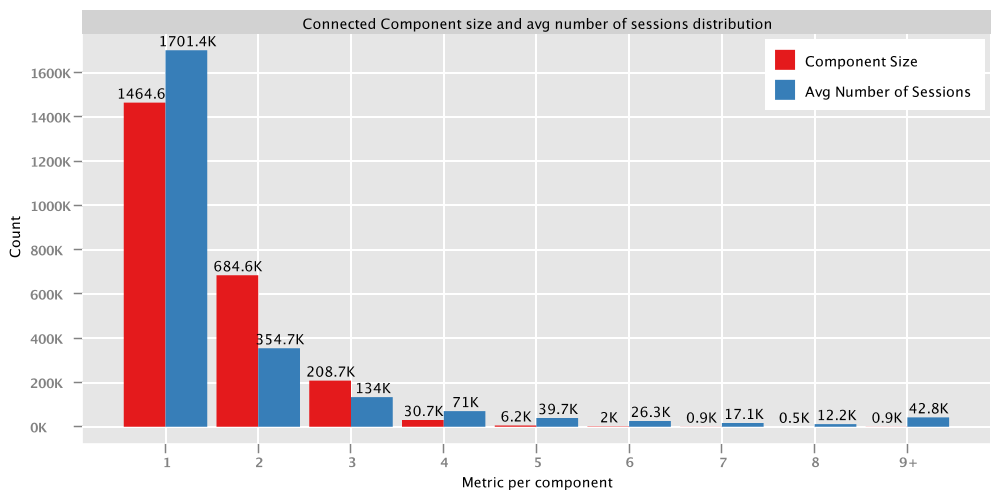

In [17]:
{
    import componentSizes.sqlContext.implicits._
    
    val bins = Array(1, 2, 3, 4, 5, 6, 7, 8, 9, 1000)

    val sizeCounts = componentSizes
        .select("component_size")
        .map { case Row(size: Long) => size }
        .rdd
        .histogram(bins.map(_.toDouble))
    
    val avgSessionCounts = componentSizes
        .select(col("average_number_of_sessions"))
        .map { case Row(a: Double) => a }
        .rdd
        .histogram(bins.map(_.toDouble))
        
    val labels = bins.slice(0, bins.size-2).map(_.toString) :+ (s"${bins(bins.size-2)}+")
    displayChart {
        import java.awt.Font
        
        val chart = new CategoryChartBuilder()
            .width(1000).height(500)
            .title("Connected Component size and avg number of sessions distribution")
            .xAxisTitle("Metric per component")
            .yAxisTitle("Count")
            .theme(style.Styler.ChartTheme.GGPlot2)
            .build()
        chart.getStyler.setSeriesColors(ggPlot2Colors)
         chart.getStyler.setYAxisDecimalPattern("#.#K")
        chart.getStyler.setHasAnnotations(true)
        chart.getStyler.setLegendPosition(Styler.LegendPosition.InsideNE)
        chart.getStyler.setAnnotationsFont(new Font(Font.SANS_SERIF, Font.PLAIN, 14))
        chart.addSeries(s"Component Size", 
            javaList(labels: _*), 
            javaDoubleList(sizeCounts.map(_ / 1000D): _*))
        chart.addSeries(s"Avg Number of Sessions", 
            javaList(labels: _*), 
            javaDoubleList(avgSessionCounts.map(_ / 1000D): _*))
        chart
    }
}

# Sampling graph and exporting it to CSV

This section is about taking samples from the graph and exporting those samples to CSV for visualisation by Cytoscape, Gephi, etc. Why sampling? Because the whole graph contains 3.5M nodes and 1.4M edges. This is too much for both Cytoscape and Gephi.

## 1. Random sampling

A function `randomConnectedComponents()` defined here is takes a random sample of components. It will be called after the definition is done

In [ ]:
val seed = 1510660773971L // this is to make all randomisations reproducible

In [ ]:
def randomConnectedComponents(seed: Long, probability: Double = 0.0002d) = {
    val randomCcNumbers = connectedComponents
        .select("component")
        .distinct
        .sample(true, probability, seed)
    
    connectedComponents
        .join(componentSizes, Seq("component"), "inner")
        .join(randomCcNumbers, Seq("component"), "inner")
}

The following function will write a dataframe with mandatory columns `"id", "id_type", "number_of_sessions", "component", "component_size"` to a CSV file. Please note, that it will create a directory and in this directory will be the 1-partition CSV file.

In [ ]:
def connectedComponentsToCsv(connectedComponentsWithSize: DataFrame, edges: DataFrame, resultName: String) {
    val n = connectedComponentsWithSize
        .select(col("id").as("Id"),
                col("id").as("Label"),
                col("id_type"),
                col("number_of_sessions"),
                col("component"),
                col("component_size"))
        
    printf("There are %d Nodes, here's a sample:%n", n.count)    
    n.show(5, false)
        
    n.repartition(1)
        .write.mode(SaveMode.Overwrite)
        .format("csv")
        .option("header", true)
        .save(s"./$resultName-nodes.csv")


    val ids = connectedComponentsWithSize.select("id")
    
    val e = edges.join(ids, ids("id") === col("src"), "left_semi")
        .select(col("src").as("Source"),
                col("dst").as("Target"))
        .distinct
        
    printf("There are %d Edges, here's a sample:%n", e.count)    
    e.show(5, false)
        
    e.repartition(1)
        .write.mode(SaveMode.Overwrite)
        .format("csv")
        .option("header", true)
        .save(s"./$resultName-edges.csv")
        
    val nJoinE = n.join(e, n("Id") === e("Source"), "left_outer")
    
    printf("There are %d Nodes joined with Edges, here's a sample:%n", nJoinE.count)    
    nJoinE.show(5, false)
    
    nJoinE.repartition(1)
        .write.mode(SaveMode.Overwrite)
        .format("csv")
        .option("header", true)
        .save(s"./$resultName-combined-nodes-and-edges.csv")
}

The following code will create 5 different samples around 700 nodes each, writing to CSV for later visualisation in Cytoscape. Aparently, Cytoscape 3.5.1 has a bug in Network Analysis tool which is very useful, and I don't know what causes it – a total number of nodes or a specific connected component. So 5 different samples gives a better chance to succeed.

In [ ]:
(1 to 5).foreach { i => 
    connectedComponentsToCsv(randomConnectedComponents(seed + i, 0.0002d), edges, s"graph-random-cc-sample-$i")    
}

## 2. Filtered sampling

The following code takes a different approach than random sampling: it filters out most of the average components and leaves peculiar outliers intact – we consult the earlier `"Connected Component size and avg session distribution"` chart to make decisions on the parameters.

In [ ]:
val connectedComponentsSizeGt2SessionsGe20 = {
    connectedComponents
        .join(componentSizes, Seq("component"), "inner")
        .filter(col("component_size") > 2)
        .filter(col("average_number_of_sessions") >= 20)
}
connectedComponentsSizeGt2SessionsGe20.count

In [ ]:
connectedComponentsToCsv(connectedComponentsSizeGt2SessionsGe20, edges, "graph-size-gt-2-sessions-ge-20")